# Shelving to clock

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi_clock(Fg, Fe, mg, me, d, pol):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff
    )
    

In [5]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [6]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.11223749592894952

In [7]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1)/1e6/2/np.pi

-0.07936389447475771

In [8]:
Rabi_clock(1/2, 1/2, -1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.07936389447475771

In [9]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [10]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [11]:
_lambda = 578e-9
omega_r = 2*np.pi*9.4e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6095349993254959
eta^2 (2n+1):  0.3715329154027323 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [12]:
N=10 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

# calibrate pi_time

In [13]:
psi0 = 1/np.sqrt(2)*(one+two)
psii = 1/np.sqrt(2)*(three-four)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [14]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.040900516094455636
ground state population 0.9607066040778716


In [15]:
B = 0e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 0.0 G


In [16]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [17]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [18]:
phi = 0
angle_pol = 5e-3

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

 ) 

Hm = omega_r*(adag*a + 1/2)

Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)
                                      
     + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32) )

H = H0 + Hm + Hd

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve(H, rho0, t_ls, c_ops, options=options, progress_bar=True)

10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.04s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.05s


In [30]:
rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.993


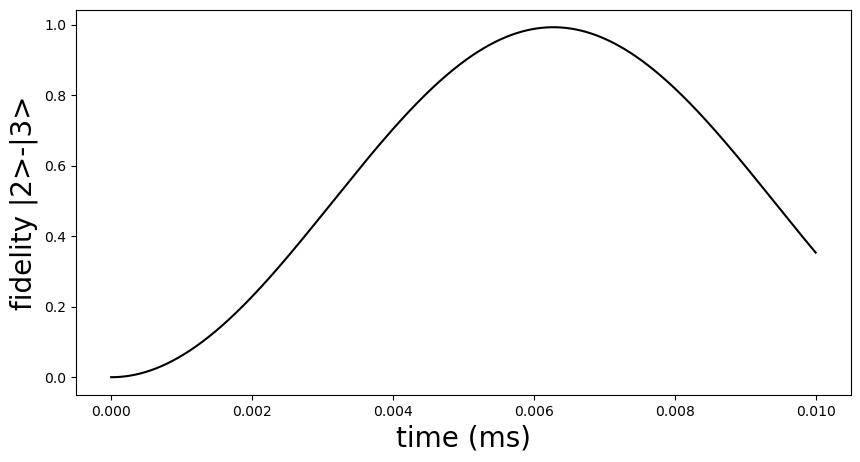

In [31]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, abs(np.array(P)), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fidelity |2>-|3>', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P))))

pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx]

(0.0, 1.0)

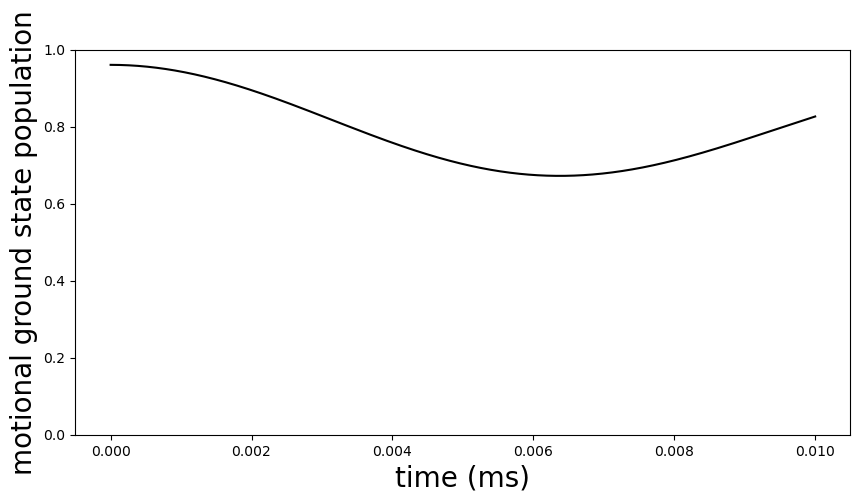

In [32]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, Pg, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'motional ground state population', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0, 0.01)

In [33]:
B_ls = np.linspace(0, 35, 100)*1e-4 #magnetic field in T

In [34]:
phi = 0
angle_pol = 5e-3

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)


tpi_ls = np.arange(0, pi_time, dt)

result_ls = []

for B in B_ls:
    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    Fg=1/2
    Fe=1/2

    #diagonal terms
    diag_1 = -delta_Ng

    diag_2 = delta_Ng

    diag_3 = -delta_Ne

    diag_4 = delta_Ne
    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

     ) 

    Hm = omega_r*(adag*a + 1/2)

    Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                           offdiag_24*sig_24 + offdiag_23*sig_23)

         + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                            + offdiag_42*sig_42 + offdiag_32*sig_32) )

    H = H0 + Hm + Hd

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    output = mesolve(H, rho0, tpi_ls, c_ops, options=options, progress_bar=True)
    result_ls.append(output)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.1%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.1%. Run time:   0.02s. Est. time left: 00:00:00:00
80.1%. Run time:   0.03s. Est. time left: 00:00:00:00
90.1%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s
10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.1%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.1%. Run time:   0.02s. Est. time left: 00:00:00:00
80.1%. Run time:   0.02s. Est. time left: 00:00:00:00
90.1%. Run time:   0.02s. Est. time left: 00:00:00:00
Tota

In [26]:
rho_ls = [out.states[-1] for out in result_ls]

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.992


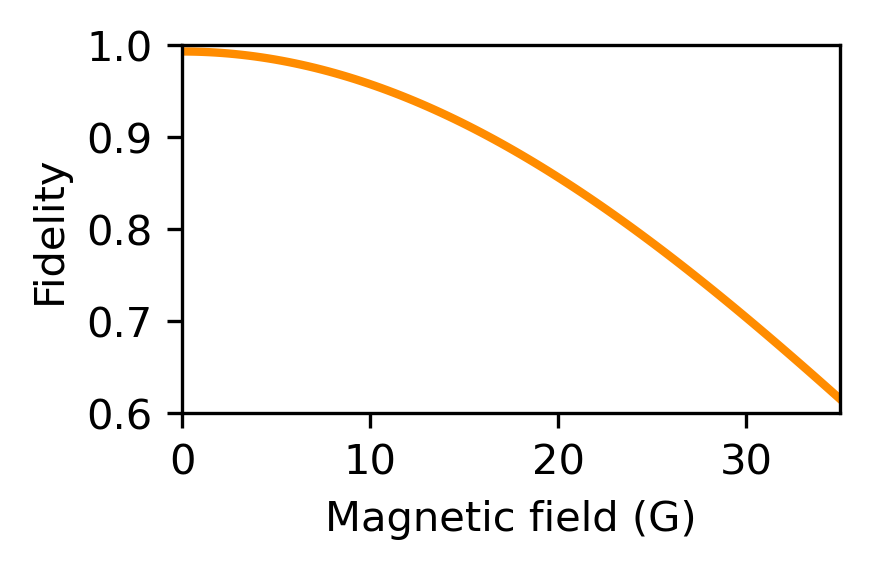

In [37]:
fig, axes = plt.subplots(1,1, dpi=300, sharex=True, figsize=(3, 2))
axes.plot(B_ls*1e4, abs(np.array(P)), color='darkorange', linestyle='-', label = 'mF=-1/2', linewidth=2)
axes.set_xlabel(r'Magnetic field (G)')
axes.set_ylabel(r'Fidelity')
print('max fidelity: %.3f' %np.max(abs(np.array(P))))
plt.ylim(0.6, 1)
plt.xlim(0, 35)
pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx]
plt.tight_layout()
plt.savefig('pipolshelve.pdf', format='pdf', dpi=300)

(0.0, 1.0)

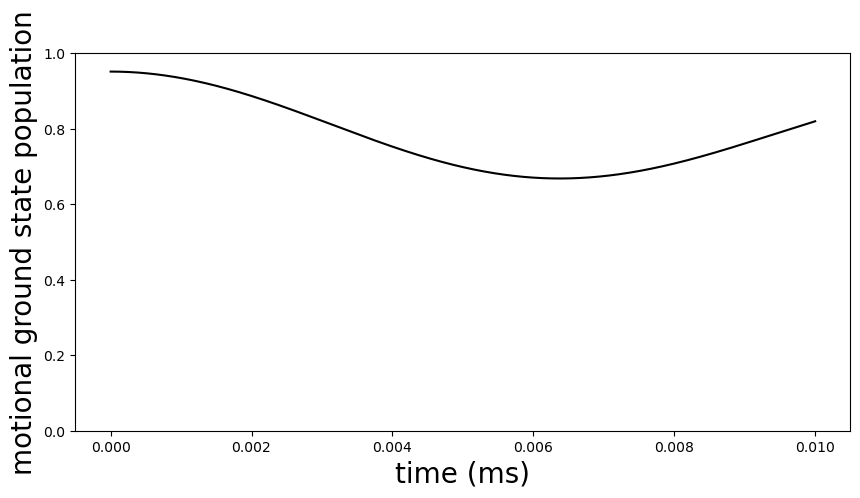

In [22]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, Pg, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'motional ground state population', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0, 0.01)

# mapping input states

In [31]:
tpi_ls = np.arange(0, pi_time, dt)

In [32]:
psi0_ls = [one, 1/np.sqrt(2)*(one+two), 1/np.sqrt(2)*(one-two), two]
state_list = [one, two, three, four]
dm_ls = [n*m.dag() for n in state_list for m in state_list]

T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*63e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0_ls = [qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) for psi0 in psi0_ls] #start in up thermal state

ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [33]:
result_ls = []

for rho0 in rho0_ls:
    output = mesolve(H, rho0, tpi_ls, c_ops, options=options, progress_bar=True)
    result_ls.append(output)

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.1%. Run time:   0.05s. Est. time left: 00:00:00:00
60.1%. Run time:   0.06s. Est. time left: 00:00:00:00
70.0%. Run time:   0.06s. Est. time left: 00:00:00:00
80.1%. Run time:   0.08s. Est. time left: 00:00:00:00
90.1%. Run time:   0.08s. Est. time left: 00:00:00:00
Total run time:   0.08s
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.02s. Est. time left: 00:00:00:00
30.1%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.03s. Est. time left: 00:00:00:00
50.1%. Run time:   0.05s. Est. time left: 00:00:00:00
60.1%. Run time:   0.05s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.1%. Run time:   0.07s. Est. time left: 00:00:00:00
90.1%. Run time:   0.07s. Est. time left: 00:00:00:00
Tota

In [34]:
dm_ls[0]

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [35]:
dm_filled = []
rho_in_ls = []

for n, output in enumerate(result_ls):
    rho =  output.states[-1]
    rho_tr = [(rho*qutip.tensor(identity(N),dm)).tr() for dm in dm_ls]
    rho_in = [(rho0_ls[n]*qutip.tensor(identity(N),dm)).tr() for dm in dm_ls]
    dm_filled.append(rho_tr)
    rho_in_ls.append(rho_in)
    

In [36]:
dm_ls[4]

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [37]:
out = [np.array(dm).reshape(4,4) for dm in dm_filled]
_input = [np.array(dm).reshape(4,4) for dm in rho_in_ls]

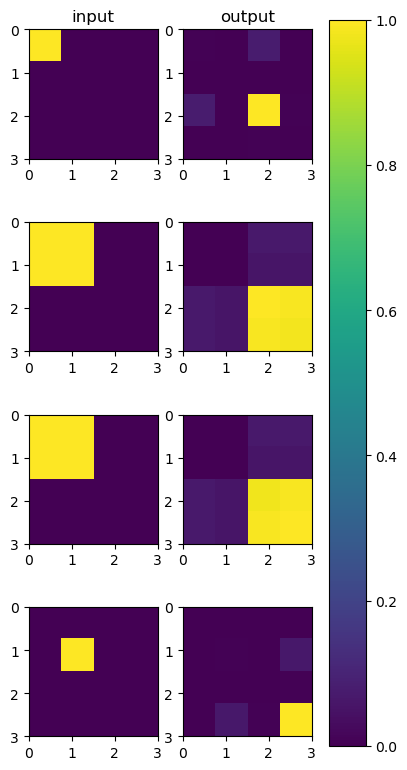

In [71]:
fig, ax = plt.subplots(4,2, figsize=(4,8))

cmap = 'viridis'
for i, o in enumerate(out):
    a = ax[i, 0].imshow(np.abs(_input[i]).reshape(4,4), cmap=cmap, origin='upper',
                   extent = [0, 3, 3,0])
    b = ax[i, 1].imshow(np.abs(o).reshape(4,4), cmap=cmap, origin='upper', extent = [0, 3, 3,0])

ax[0, 0].set_title('input')
ax[0, 1].set_title('output')
plt.tight_layout()
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
    

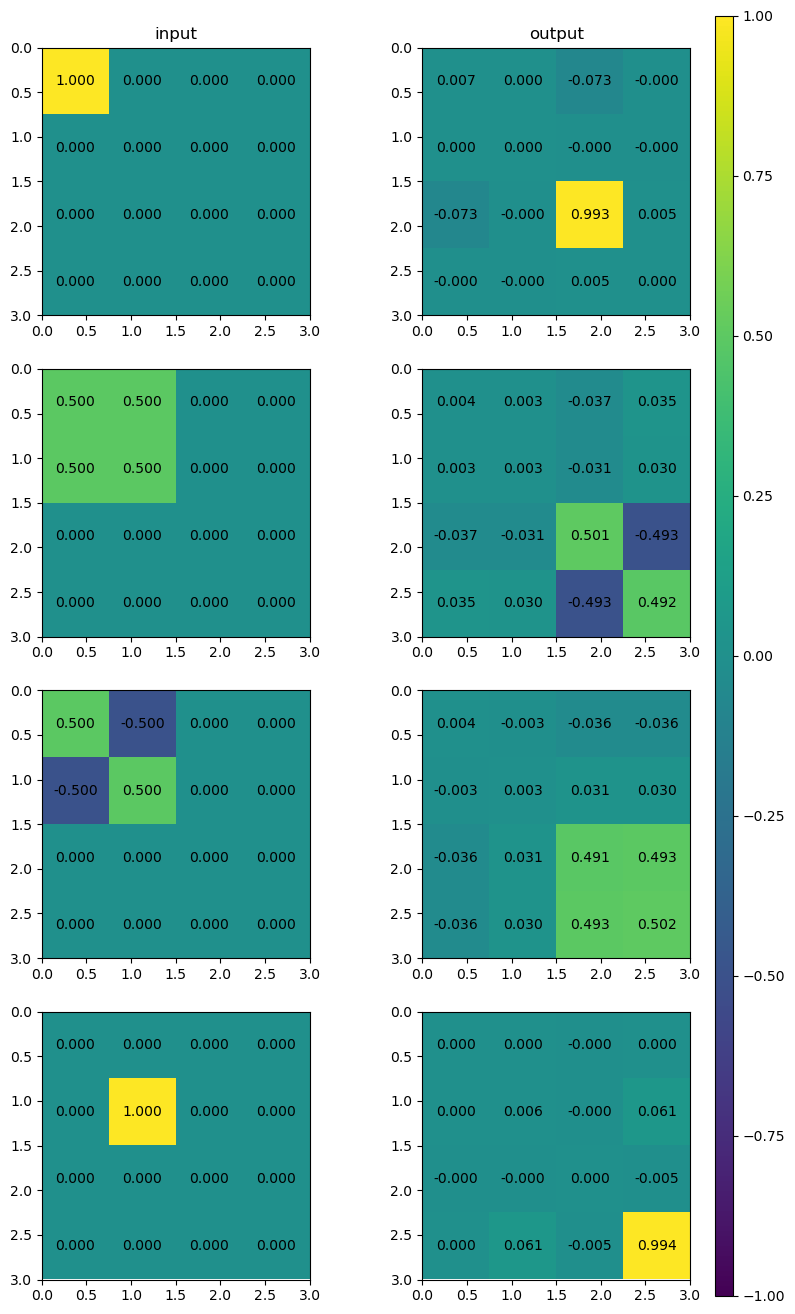

In [126]:
size = 4

# Limits for the extent
x_start = 0
x_end = 3
y_start = 0
y_end = 3

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig, ax = plt.subplots(4,2, figsize=(9, 16))

cmap = 'viridis'
for i, o in enumerate(out):
    data1 = np.real(_input[i]).reshape(4,4)
    a = ax[i, 0].imshow(data1, cmap=cmap, origin='upper',
                   extent = [0, 3, 3,0], vmin=-1, vmax=1)
    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = data1[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax[i, 0].text(text_x, text_y, "{:.3f}".format(label), color='black', ha='center', va='center')

    data2 = np.real(o).reshape(4,4)        
    b = ax[i, 1].imshow(data2, cmap=cmap, origin='upper', extent = [0, 3, 3,0], vmin=-1, vmax=1)
    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = data2[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax[i, 1].text(text_x, text_y, "{:.3f}".format(label), color='black', ha='center', va='center')
            
            
ax[0, 0].set_title('input')
ax[0, 1].set_title('output')

cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fig.colorbar(a, cax=cb_ax)

plt.savefig( "mcm_map_sig_real.png", format="png", dpi=300)

# calibrate pi_time

In [13]:
psi0 = 1/np.sqrt(2)*(one+two)
psii = 1/np.sqrt(2)*(three-four)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [14]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.040900516094455636
ground state population 0.9607066040778716


In [15]:
B = 1.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.4999999999999998 G


In [16]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [17]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [18]:
phi = 0
angle_pol = 5e-3

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

 ) 

Hm = omega_r*(adag*a + 1/2)

Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)
                                      
     + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32) )

H = H0 + Hm + Hd

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve(H, rho0, t_ls, c_ops, options=options, progress_bar=True)

10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.04s


In [19]:
rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.992


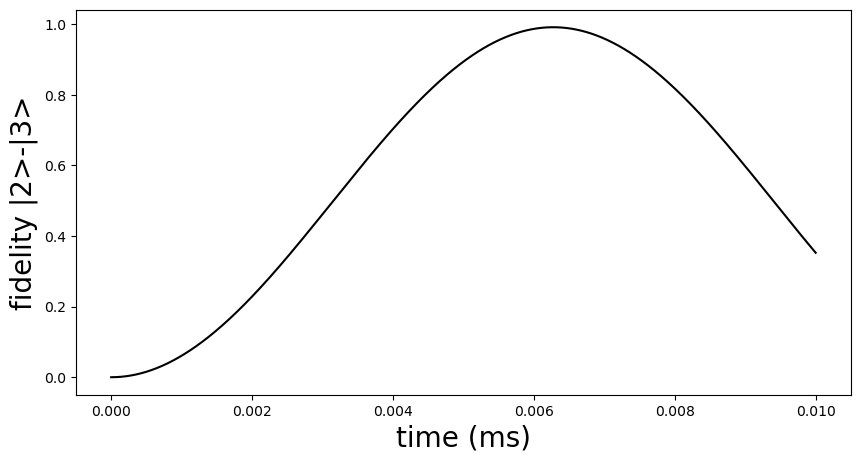

In [20]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, abs(np.array(P)), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fidelity |2>-|3>', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P))))

pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx]

# run simulation

In [21]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)

rho0_ls = []
phase_ls = np.linspace(0, 2*np.pi, 100)
for phase in phase_ls:
    psi0 = 1/np.sqrt(2)*(one+np.exp(-1j*phase)*two)
    rho0_ls.append(qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag())) #start in up thermal state)

In [22]:
B = 1.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.4999999999999998 G


In [23]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [24]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [25]:
tpi_ls = np.arange(0, pi_time+dt, dt)
twait = 1e-3
m=100

phi = 0
angle_pol = 5/180*np.pi

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

 ) 

Hm = omega_r*(adag*a + 1/2)

Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)
                                      
     + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32) )

H = H0 + Hm + Hd

Hw = H0 + Hm

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output_ls = []

for i, rho0 in enumerate(rho0_ls):
    print(i)

    output0 = mesolve(H, rho0, tpi_ls, c_ops, options=options)

    rho1 = output0.states[-1]

    output1 = mesolve(Hw, rho1, np.arange(pi_time, pi_time+twait+(twait)/m, (twait)/m), c_ops, options=options)

    rho2 = output1.states[-1]

    output2 = mesolve(H, rho2, np.arange(pi_time+twait, 2*pi_time+twait+dt, dt), c_ops, options=options)
    
    output_ls.append(output2.states[-1])
    print(i)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99


In [26]:
psii =  1/np.sqrt(2)*(one+two)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

rho_ls = output2.states

P = [(i_proj*rho).tr()  for rho in output_ls]
Pg = [(ground_proj*rho).tr()  for rho in output_ls]

max fidelity: 0.969


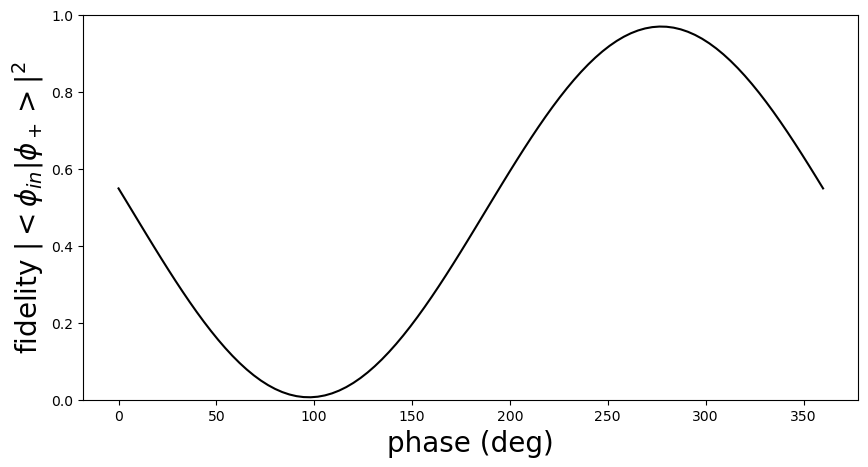

In [27]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(phase_ls*180/np.pi, abs(np.array(P)), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'phase (deg)', fontsize=20)
axes.set_ylabel(r'fidelity $|<\phi_{in}|\phi_+>|^2$', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P))))
plt.ylim(0, 1);

In [25]:
phi = 0
angle_pol = 5e-3

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)


tpi_ls = np.arange(0, pi_time, dt)

result_ls = []

for B in B_ls:
    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    Fg=1/2
    Fe=1/2

    #diagonal terms
    diag_1 = -delta_Ng

    diag_2 = delta_Ng

    diag_3 = -delta_Ne

    diag_4 = delta_Ne
    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

     ) 

    Hm = omega_r*(adag*a + 1/2)

    Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                           offdiag_24*sig_24 + offdiag_23*sig_23)

         + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                            + offdiag_42*sig_42 + offdiag_32*sig_32) )

    H = H0 + Hm + Hd

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    output = mesolve(H, rho0, tpi_ls, c_ops, options=options, progress_bar=True)
    result_ls.append(output)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.1%. Run time:   0.02s. Est. time left: 00:00:00:00
60.1%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.1%. Run time:   0.03s. Est. time left: 00:00:00:00
90.1%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.04s
10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.1%. Run time:   0.02s. Est. time left: 00:00:00:00
60.1%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.1%. Run time:   0.03s. Est. time left: 00:00:00:00
90.1%. Run time:   0.04s. Est. time left: 00:00:00:00
Tota

In [26]:
rho_ls = [out.states[-1] for out in result_ls]

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.992


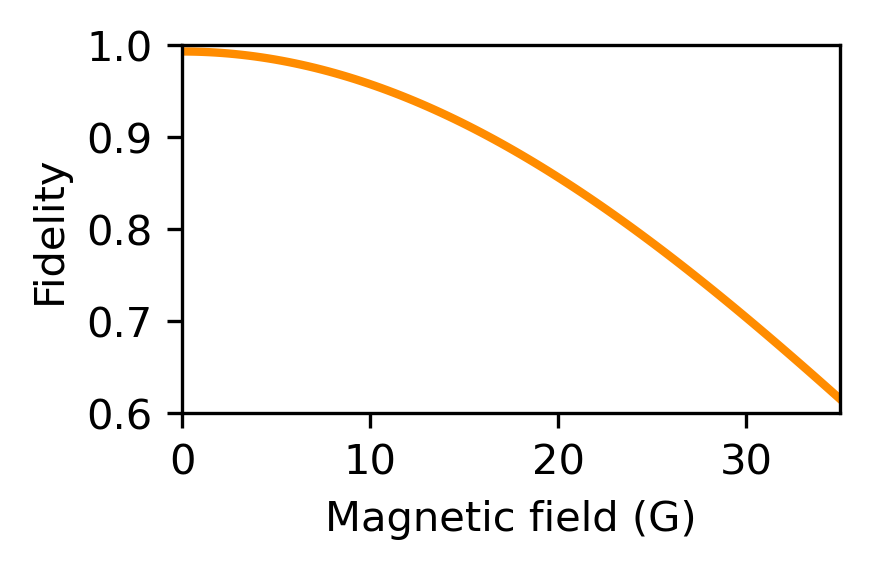

In [37]:
fig, axes = plt.subplots(1,1, dpi=300, sharex=True, figsize=(3, 2))
axes.plot(B_ls*1e4, abs(np.array(P)), color='darkorange', linestyle='-', label = 'mF=-1/2', linewidth=2)
axes.set_xlabel(r'Magnetic field (G)')
axes.set_ylabel(r'Fidelity')
print('max fidelity: %.3f' %np.max(abs(np.array(P))))
plt.ylim(0.6, 1)
plt.xlim(0, 35)
pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx]
plt.tight_layout()
plt.savefig('pipolshelve.pdf', format='pdf', dpi=300)

(0.0, 1.0)

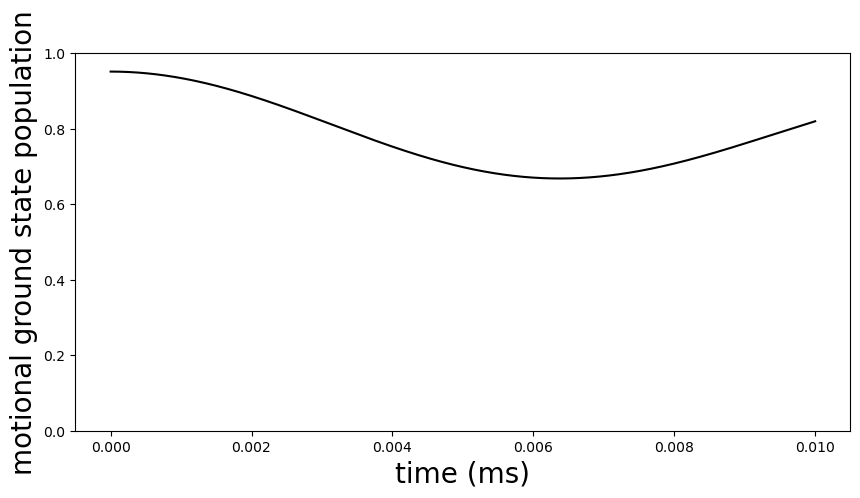

In [22]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, Pg, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'motional ground state population', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0, 0.01)

# mapping input states

In [31]:
tpi_ls = np.arange(0, pi_time, dt)

In [32]:
psi0_ls = [one, 1/np.sqrt(2)*(one+two), 1/np.sqrt(2)*(one-two), two]
state_list = [one, two, three, four]
dm_ls = [n*m.dag() for n in state_list for m in state_list]

T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*63e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0_ls = [qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) for psi0 in psi0_ls] #start in up thermal state

ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [33]:
result_ls = []

for rho0 in rho0_ls:
    output = mesolve(H, rho0, tpi_ls, c_ops, options=options, progress_bar=True)
    result_ls.append(output)

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.1%. Run time:   0.05s. Est. time left: 00:00:00:00
60.1%. Run time:   0.06s. Est. time left: 00:00:00:00
70.0%. Run time:   0.06s. Est. time left: 00:00:00:00
80.1%. Run time:   0.08s. Est. time left: 00:00:00:00
90.1%. Run time:   0.08s. Est. time left: 00:00:00:00
Total run time:   0.08s
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.02s. Est. time left: 00:00:00:00
30.1%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.03s. Est. time left: 00:00:00:00
50.1%. Run time:   0.05s. Est. time left: 00:00:00:00
60.1%. Run time:   0.05s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.1%. Run time:   0.07s. Est. time left: 00:00:00:00
90.1%. Run time:   0.07s. Est. time left: 00:00:00:00
Tota

In [34]:
dm_ls[0]

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [35]:
dm_filled = []
rho_in_ls = []

for n, output in enumerate(result_ls):
    rho =  output.states[-1]
    rho_tr = [(rho*qutip.tensor(identity(N),dm)).tr() for dm in dm_ls]
    rho_in = [(rho0_ls[n]*qutip.tensor(identity(N),dm)).tr() for dm in dm_ls]
    dm_filled.append(rho_tr)
    rho_in_ls.append(rho_in)
    

In [36]:
dm_ls[4]

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [37]:
out = [np.array(dm).reshape(4,4) for dm in dm_filled]
_input = [np.array(dm).reshape(4,4) for dm in rho_in_ls]

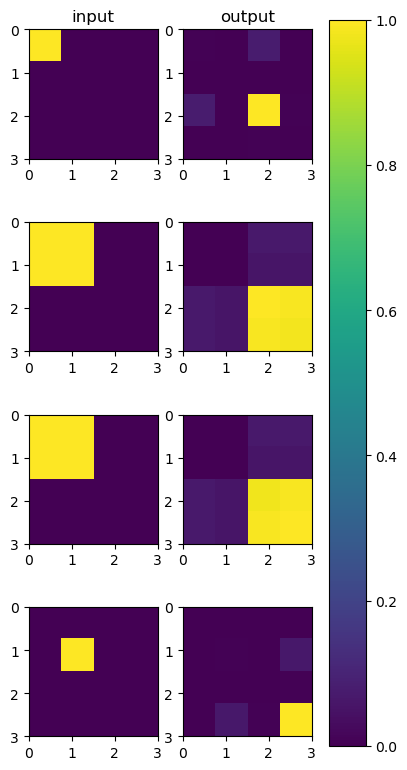

In [71]:
fig, ax = plt.subplots(4,2, figsize=(4,8))

cmap = 'viridis'
for i, o in enumerate(out):
    a = ax[i, 0].imshow(np.abs(_input[i]).reshape(4,4), cmap=cmap, origin='upper',
                   extent = [0, 3, 3,0])
    b = ax[i, 1].imshow(np.abs(o).reshape(4,4), cmap=cmap, origin='upper', extent = [0, 3, 3,0])

ax[0, 0].set_title('input')
ax[0, 1].set_title('output')
plt.tight_layout()
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
    

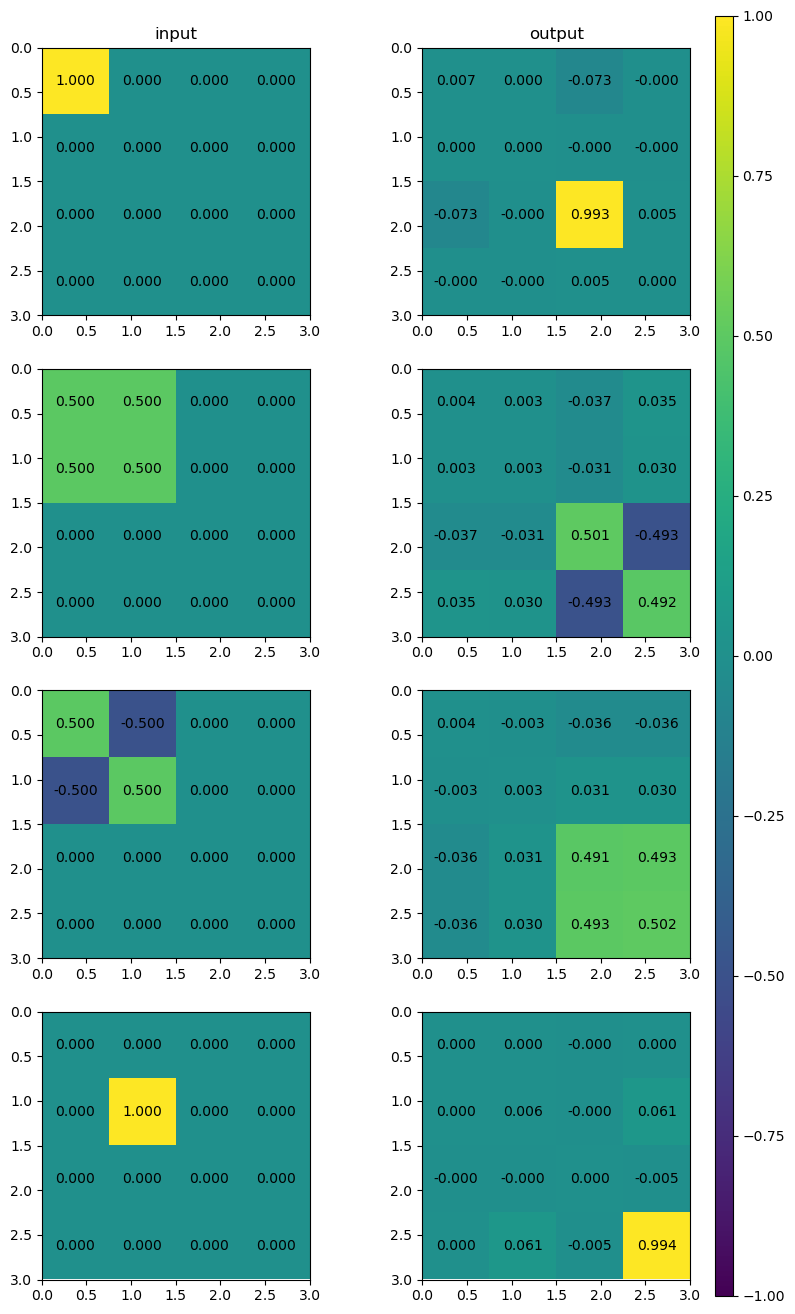

In [126]:
size = 4

# Limits for the extent
x_start = 0
x_end = 3
y_start = 0
y_end = 3

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig, ax = plt.subplots(4,2, figsize=(9, 16))

cmap = 'viridis'
for i, o in enumerate(out):
    data1 = np.real(_input[i]).reshape(4,4)
    a = ax[i, 0].imshow(data1, cmap=cmap, origin='upper',
                   extent = [0, 3, 3,0], vmin=-1, vmax=1)
    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = data1[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax[i, 0].text(text_x, text_y, "{:.3f}".format(label), color='black', ha='center', va='center')

    data2 = np.real(o).reshape(4,4)        
    b = ax[i, 1].imshow(data2, cmap=cmap, origin='upper', extent = [0, 3, 3,0], vmin=-1, vmax=1)
    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = data2[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax[i, 1].text(text_x, text_y, "{:.3f}".format(label), color='black', ha='center', va='center')
            
            
ax[0, 0].set_title('input')
ax[0, 1].set_title('output')

cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fig.colorbar(a, cax=cb_ax)

plt.savefig( "mcm_map_sig_real.png", format="png", dpi=300)